# Neural Network with 1 Hidden Layer for Classification

We implement a neural network with a single hidden layer (having `h` units/neurons) to classify a multi-class labeled dataset.

**Loss Calculation**

For the $i$-th sample:

$$l_i = - \sum_{j=1}^n y_{ij} \log{p_{ij}}$$

if we use one-hot encoded `y_true` then the sum is simply picking out the log-prob of the true class.

Total loss is defined as:

$$\mathcal{L} = \frac{1}{m}\sum_{i=1}^m l_i$$

**$dW2$, $db2$ calculation**

$$dZ2 = \frac{dJ}{dA_2}\times\frac{dA_2}{dZ_2} = A_2 - y$$

$$dW2 = \frac{dJ}{dA_2}\times\frac{dA_2}{dZ_2}\times\frac{dZ_2}{dW_2}=(A_2 - y)\times A_1$$
$$db2 = \frac{dJ}{dA_2}\times\frac{dA_2}{dZ_2}\times\frac{dZ_2}{db_2}= A_2 - y $$

Similarly, **$dW1$, $db1$ calculation**

$$dW1 = \frac{dJ}{dA_2}\times\frac{dA_2}{dZ_2}\times\frac{dZ_2}{dA_1}\times\frac{dA_1}{dZ_1}\times\frac{dZ_1}{dW_1}$$
$$db1 = \frac{dJ}{dA_2}\times\frac{dA_2}{dZ_2}\times\frac{dZ_2}{dA_1}\times\frac{dA_1}{dZ_1}\times\frac{dZ_1}{db_1}$$

here $\frac{dA_1}{dZ_1}$ is step function with value 1 if $z>0$ else 0.

$$dW1 = \frac{dJ}{dZ1}\times\frac{dZ_1}{dW_1} = dZ1\times X $$
$$db1 = \frac{dJ}{dZ1}\times\frac{dZ_1}{db_1} = dZ1 $$

---

### Model Architecture

The neural network has the following structure:

* **Input layer**: 2 features
* **Hidden layer**: 4 neurons, ReLU activation
* **Output layer**: 3 neurons, Softmax activation
* **Loss**: Categorical cross-entropy (integer class labels)


Here's the actual code:

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('data.csv')

X = df.drop('y', axis=1).values
y = df['y'].values

m = X.shape[0]  # no of training samples = 300
d = X.shape[1]  # no of input features = 2
n = len(np.unique(y))  # no of output neurons = 3
h = 4  # no of units in hidden layer
learning_rate = 0.1

rng = np.random.default_rng(13)

max_iter = 5000
verbose = False
losses = []
accuracies = []


def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True)  # for numerical stability
    t = np.exp(x)
    return t/np.sum(t, axis=1, keepdims=True)


# random initialization
W1 = rng.normal(size=(d, h))
b1 = np.zeros(shape=(1, h))
W2 = rng.normal(size=(h, n))
b2 = np.zeros(shape=(1, n))

for iter in range(max_iter):
    # forward prop
    Z1 = X@W1 + b1
    A1 = np.maximum(0, Z1)  # relu
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)

    y_preds = np.argmax(A2, axis=1)
    acc = np.mean(y_preds == y)
    accuracies.append(acc)

    preds = np.clip(A2, 1e-15, 1)  # for numerical stability

    # loss calculation
    loss = -np.mean(np.log(preds[np.arange(len(y)), y]))
    losses.append(loss)
    if iter % 100 == 0 and verbose:
        print(f'{iter=}, {loss=}')

    # back prop
    dZ2 = A2.copy()
    dZ2[np.arange(m), y] -= 1  # doing A2-y
    dZ2 /= m  # this is (A2-y)/m which is actual dZ2
    dW2 = A1.T@dZ2
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, W2.T)  # dA1 = dZ2 x (dZ2/dA1) = dZ2 x W2
    # dZ1 = dA1 * (Z1>0)
    # or fir more clarity:
    dA1[Z1 <= 0] = 0  # setting derivatives to zero when Z1<0
    dZ1 = dA1  # dZ1 = (dJ/dZ1)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    # updating the weights and biases
    W1 -= learning_rate*dW1
    W2 -= learning_rate*dW2
    b1 -= learning_rate*db1
    b2 -= learning_rate*db2

print(
    f'After {max_iter} iterations, we have loss {losses[-1]:0.4f} and accuracy {accuracies[-1]:0.4f}')

After 5000 iterations, we have loss 0.2649 and accuracy 0.9067


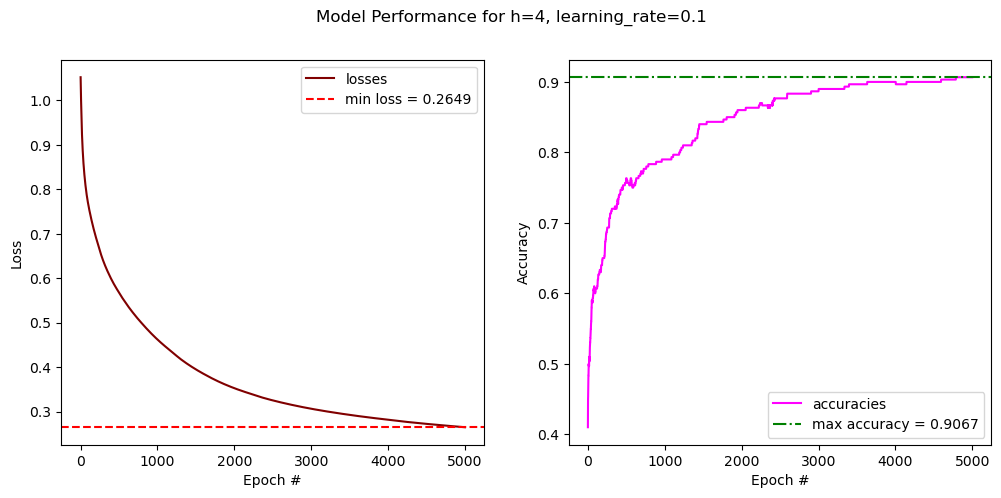

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

min_loss = np.min(losses)
max_acc = np.max(accuracies)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle(f'Model Performance for {h=}, {learning_rate=}')

sns.lineplot(x=range(max_iter), y=losses,
             label='losses', ax=axs[0], color='maroon')
axs[0].axhline(np.min(losses), color='r', linestyle='--',
               label=f'min loss = {min_loss:.4f}')
axs[0].set_xlabel('Epoch #')
axs[0].set_ylabel('Loss')
axs[0].legend()

sns.lineplot(x=range(max_iter), y=accuracies,
             label='accuracies', ax=axs[1], color='magenta')
axs[1].axhline(np.max(accuracies), color='g', linestyle='-.',
               label=f'max accuracy = {max_acc:.4f}')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch #')
axs[1].legend()
plt.show()

## Decision Boundary Visualization


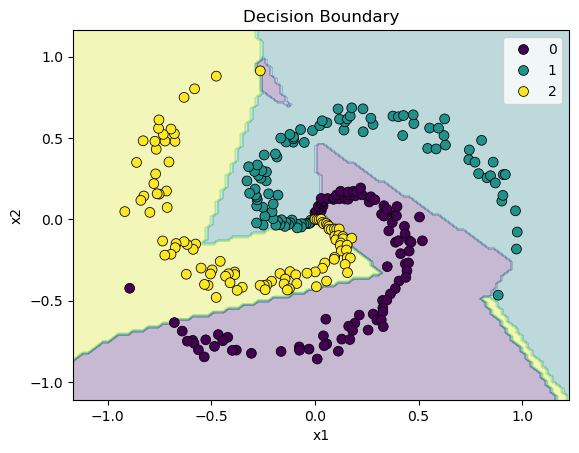

In [3]:
# creating a mesh grid for the decision boundary
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# making predictions
Z1_mesh = np.c_[xx.ravel(), yy.ravel()] @ W1 + b1
A1_mesh = np.maximum(0, Z1_mesh)
Z2_mesh = A1_mesh @ W2 + b2
A2_mesh = softmax(Z2_mesh)
Z_mesh = np.argmax(A2_mesh, axis=1).reshape(xx.shape)

# plotting the decision boundary
plt.contourf(xx, yy, Z_mesh, alpha=0.3, cmap='viridis')
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=50,
                palette='viridis', edgecolor='black')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Boundary')
plt.show()

## Comparison with MLPClassifier of sklearn
Let us now build the same NN model with MLPClassifier from sklearn:

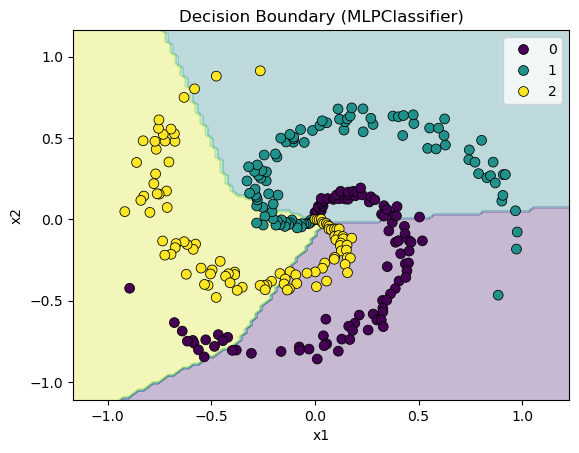

In [4]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(
                        hidden_layer_sizes=4, 
                        activation='relu',
                        learning_rate='constant',
                        learning_rate_init=0.1, 
                        max_iter=5000,
                        random_state=13
                    )
mlpc.fit(X, y)
mlpc.score(X, y)

# making predictions with MLPClassifier using the earlier mesh grid
Z_mesh = mlpc.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# plotting the decision boundary
plt.contourf(xx, yy, Z_mesh, alpha=0.3, cmap='viridis')
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=50,
                palette='viridis', edgecolor='black')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Boundary (MLPClassifier)')
plt.show()

The performance is not good at all in comparison with our from-scratch implementation. Unlike our code, MLPClassifier is highly optimized and so using a large `learning_rate = 0.1` as we did for our code is counter-productive in this case. So let us try changing it to `0.01` which is far more reasonable.

Another important factor could be that MLPClassifier uses regularization by default. We can try changing it as well.

However, the key takeaway is that it is not exactly an apples to apples comparison. 



In [14]:
mlpc = MLPClassifier(
                        hidden_layer_sizes=4, 
                        activation='relu',
                        learning_rate='constant',
                        learning_rate_init=0.01, 
                        max_iter=5000,
                        random_state=13,
                        alpha=0.0
                    )
mlpc.fit(X, y)
mlpc.score(X, y)

0.6833333333333333

MLPClassifier also has early stopping in built. This can be seen by checking how many iterations actually happened during training.

In [ ]:
mlpc.n_iter_

446

There's only 446 iterations, even though we had set the max as 5000. Our implementation on the other hand does go through 5000 iterations!